# Optimizing Stock Portfolio Strategies: A Machine Learning Approach with Factor Investing

In [1]:
# pip install statsmodels
# pip install scikit-learn
# pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates 

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

import random

from sklearn import tree
from sklearn import metrics

# Import Dataset :
the dataset contains monthly observation of 30 stock’s price and 6 associated smart beta from 31.12.1999 to 26.02.2021. The format of the original dataset is .Rdata and I then convert it to xlsx, to be able to open it with excel. (I start my project with the excel dataset, so I don't run this cell. You can remove the # and run it if you want to start with the .Rdata dataset).

In [4]:
# pip install pyreadr
# pip install pandas openpyxl

# import pyreadr

# dataframe = pyreadr.read_r('data.RData')
# dataframe = pd.DataFrame(dataframe['data'])
# dataframe.to_excel('dataframe.xlsx', index=False, engine='openpyxl')

Now I load the dataset from excel into df.

In [5]:
# Load data from Excel
df = pd.read_excel('dataframe.xlsx')

#   Data Cleaning :
I first selected only the price, the stock_name and the 5 smart beta and removed the last column. Then I filter the data, removing december 1999, 2021 and 2020 apart from January and rename close by price and tick by stock_name.

In [6]:
# Select first eight columns including date, stock's name, price and 5 smart beta
df = df.iloc[:,0:8]

# Filter data by specific dates: Removing december 1999, 2020(expect january) and 2021
# In order to have the monthly observations over 20 years.
df = df[~(df['Date'].dt.year == 2021)]
df = df[~((df['Date'].dt.year == 2020) & (df['Date'].dt.month != 1))]
df = df[~((df['Date'].dt.year == 1999) & (df['Date'].dt.month == 12))]

# Rename the columns Close and Tick by price and stock_name
df.rename(columns={'Close': 'price'}, inplace=True)
df.rename(columns={'Tick': 'stock_name'}, inplace=True)

### Missing Value and Outlier :
I now check for missing value and print min and max data of each column.

In [7]:
# Calculate the number of missing values in each column
df.isnull().sum()

stock_name    0
Date          0
price         0
Vol_1M        0
Mkt_Cap       0
P2B           0
D2E           0
Prof_Marg     0
dtype: int64

In [8]:
# Loop through columns 3 to 8
for i in range(2, 8):
    # Store the column name of each column
    column = df.columns[i]
    # Calculate the minimum value of each column
    minimum = df[column].min()
    # Calculate the maximum value of each column
    maximum = df[column].max()
    # Print column, max and min
    print(str(column))
    print('max : ' + str(maximum))
    print('min : ' + str(minimum))
    print('')

price
max : 442.9873
min : 0.217

Vol_1M
max : 268.563
min : 5.867

Mkt_Cap
max : 1354254.8148
min : 4467.1598

P2B
max : 1678.9053
min : 0.1013

D2E
max : 14585.6122
min : 0.0

Prof_Marg
max : 145.5825
min : -106.26



### Future price and return :
Then I added a columns price_future with the future next month price of the stock and a column return_future with the return of the next month. Then I remove the observations of january 2020 so I have 240 monthly observations over 20 years for each stocks.

In [9]:
# Add columns of future prices and future returns
df['price_future'] = df['price'].shift(-1)
df['return_future'] = (df['price_future'] - df['price'])/df['price']

# Remove the Date january 2020 (was useful only to compute future price and returns)
df = df[~((df['Date'].dt.year == 2020) & (df['Date'].dt.month == 1))]

# Create lists of every dates and every stock 
liste_date = set(df['Date']) 
liste_stock = df['stock_name'].unique().tolist()

# Set stock_name and Date as index
df = df.set_index(['stock_name','Date'])

# Cumulative Returns :
I create a def called cumulative_returns that return the cumulative returns of an investment when you enter a list of monthly returns. 

In [10]:
def cumulative_returns(monthly_returns):
    # Initialize cumulative_returns to 1 at date 0
    cumulative_returns = 1
    # Create an empty list to store the cumulative returns over time
    list_cumulative_returns = []

    # Iterate through each monthly return
    for i in monthly_returns:
        # Update cumulative_returns by including the new monthly return
        cumulative_returns *= (1 + i)
        # Append the current cumulative_returns to the list
        list_cumulative_returns.append(cumulative_returns)
    
    # Convert the list of cumulative returns to a dataframe that align with the monthly_returns index
    list_cumulative_returns = pd.DataFrame(
        list_cumulative_returns,
        index=monthly_returns.index,
        columns=['cumulative_returns'])
    
    # Return the DataFrame containing cumulative returns.
    return list_cumulative_returns

# Equal Weighted Portfolio :
I create an equal weighted portfolio that invest equally in every stock. To do so I compute the average future return for every month and then I compute the cumulative returns of those monthly returns. Then I show on a graph the cumulative returns for the test period.

In [11]:
# Group the dataframe by 'Date' and calculate the average of 'return_future' for each date
returns_equal = df.groupby('Date')['return_future'].mean()
returns_equal.name = 'returns_equal'

# Split the data into training and testing sets without shuffling to maintain the time series order
returns_equal_train, returns_equal_test = train_test_split(returns_equal, test_size=0.2, shuffle=False)

# Calculate the cumulative returns from the test data to simulate the growth of an equal weigthed portfolio
cumulative_returns_equal_test = cumulative_returns(returns_equal_test)

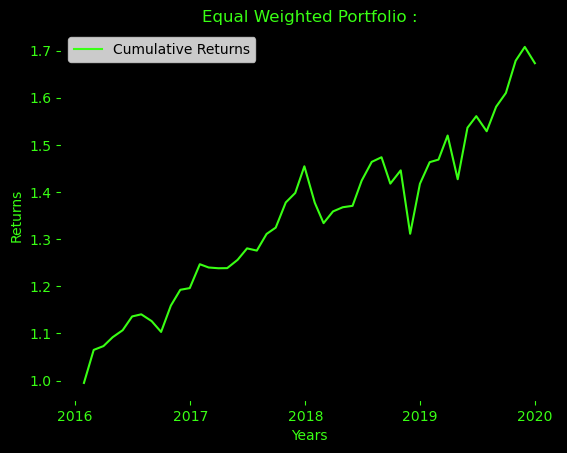

In [12]:
# Plot the cumulative returns over time of the equaly weigthed portfolio fot the test data
plt.plot(cumulative_returns_equal_test, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.title('Equal Weighted Portfolio :', color='#39FF14')
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('Equal.pdf')
plt.show()

# Market Cap Weighted Portfolio :
I create a market cap weighted portfolio. I first create a column sum_mkt_cap with the sum of every market cap each month. Then I create a column %mkt_cap which represent for each stock at each date their percentage of the total market cap. Next, I calculated the %return for each stock at each date which is their weighted return in the portfolio. Then I compute the portfolio return for each month by adding the %return of every stock at each date. Finally I compute the cumulative returns of those monthly returns. Then I show on a graph the cumulative returns for the test period.

In [13]:
# Calculate the total market capitalization for each date across all stocks
df['sum_mkt_cap'] = df.groupby('Date')['Mkt_Cap'].transform('sum') 

# Compute each stock's percentage of the total market cap on each date
df['%mkt_cap'] = df['Mkt_Cap'] / df['sum_mkt_cap']

# Calculate the weighted return of a market cap weighted portfolio
# for each stock on each date based on its market cap percentage
df['%return'] = df['%mkt_cap'] * df['return_future'] 

# Sum up all weighted returns for each date to get the total market return of the portfolio for that date
returns_marketcap = df.groupby('Date')['%return'].sum() 
returns_marketcap.name = 'bench_returns'

# Split the benchmark returns into training and testing datasets, maintaining chronological order.
returns_marketcap_train, returns_marketcap_test = train_test_split(returns_marketcap, test_size=0.2, shuffle=False)

# Calculate the cumulative returns from the test data to simulate the growth of an market cap weigthed portfolio
cumulative_returns_marketcap_test = cumulative_returns(returns_marketcap_test)

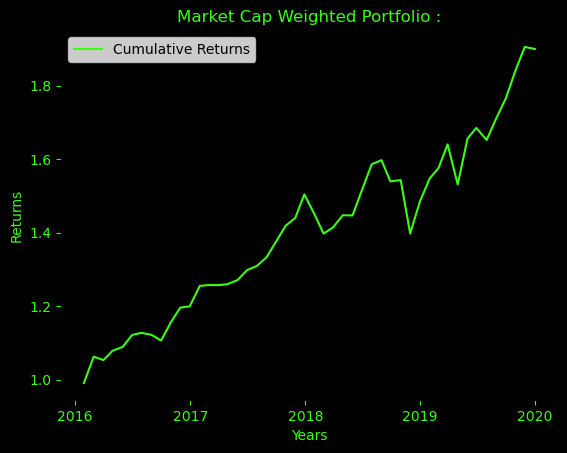

In [14]:
# Plot the cumulative returns over time of the equaly weigthed portfolio fot the test data
plt.plot(cumulative_returns_marketcap_test, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.title('Market Cap Weighted Portfolio :', color='#39FF14')
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')

# Set the X-axis to only show years the beginning of each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('MarketCap.pdf')
plt.show()

# Create X and y :
I will create a dummies dataframe for each stock at each date. Then I will create the dependant variable y with the future price and the independent variable X with the 5 smart beta. I will also standardize the X's. Finally I create a Serie with the price of each stock at each date that will be useful later.

In [15]:
# Remove index
df = df.reset_index()

# Sort by Date and set Date as index
df = df.sort_values(by='Date')
df = df.set_index('Date')

# Generate dummy variables for each stock
dummies = pd.get_dummies(df['stock_name'], drop_first=False)

In [16]:
# Select the future_price column of df as y
y = df.iloc[:,7:8]

# Select the 5 smart beta of df as X
X = df.iloc[:,2:7]

# Preserve the index and column names of X
X_index = X.index
X_columns = X.columns

# Standardize the X's
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert the standardized X back to a dataframe with the original index and columns
X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [17]:
# Create a dataframe called price with the column price and split it into train and test.
price = df['price']
price_train, price_test = train_test_split(price, test_size=0.2,shuffle=False)

# Polynomial Regression :

### Creating X's for a polynomial degree n :
I first create a def called polynomial that transform the X to a polynomial with degree n and then concatenate the dummies. 

In [18]:
def polynomial(X, n):
    # Transform X to a polynomial with degree n called X_poly
    poly = PolynomialFeatures(degree=n)
    X_poly = poly.fit_transform(X)
    
    # Convert X_poly back to a DataFrame with the original index
    X_poly = pd.DataFrame(X_poly, index=X_index)
    
    # Concatenate X_poly with the dummies into X_poly_dummies
    X_poly_dummies = pd.concat([X_poly, dummies], axis=1)
    X_poly_dummies.columns = X_poly_dummies.columns.astype(str)
    
    return X_poly_dummies

### Predicting y_pred with Linear Regression :
I create a def called reg_y_pred that return y_pred_train and y_pred_test of a model that do a linear regression with the X_train and the y_train.

In [19]:
def reg_y_pred(X_train, y_train, X_test):
    # Fit the linear regression model on the training data 
    regression_model = LinearRegression(fit_intercept=False) 
    regression_model.fit(X_train, y_train)
    
    # Predict the y variable for training data
    y_pred_train = regression_model.predict(X_train)
    
    # Predict the y variable for testing data
    y_pred_test = regression_model.predict(X_test)
    
    # Return predictions for both training and testing data
    return y_pred_train, y_pred_test

### Testing different polynomial degree to see MSE Train and Test evolution :
I am testing for different polynomial degree the regression and I add in a dataframe the polynomial degree, the train mse and the test mse to see how it evolve and to avoid overfitting. Then I plot it in a graph.

In [20]:
# Initialize a dataframe to store polynomial degrees and their associate mean squared errors
result = pd.DataFrame(columns=['poly_degree', 'mse_train', 'mse_test'])

# Loop through polynomial degrees from 1 to 4
for i in range(1, 5):
    
    # Generate X_poly_dumies for current degree i
    X_poly_dummies = polynomial(X, i)
    
    # Split the data into training and testing sets without shuffling to preserve time series order
    X_train, X_test, y_train, y_test = train_test_split(X_poly_dummies, y, test_size=0.2, shuffle=False)
    
    # Predict y using the regression model for both train and test datasets
    y_pred_train = reg_y_pred(X_train, y_train, X_test)[0]
    y_pred_test = reg_y_pred(X_train, y_train, X_test)[1]
    
    # Calculate the mean squared error for train and apply the natural logarithm
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_train = np.log(mse_train)

    # Calculate the mean squared error for test and apply the natural logarithm
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_test = np.log(mse_test)
    
    # Add a new raw to the dataset result with the current polynomial degree and the associate mse
    new_row = pd.DataFrame({'poly_degree': [str(i)], 'mse_train': [mse_train], 'mse_test': [mse_test]})
    
    # Append the new row to the result DataFrame
    result = pd.concat([result, new_row], ignore_index=True)
    
# Name the polynomial degree as the index of the dataset result
result = result.set_index('poly_degree')

# Show the dataset result
result

,mse_train,mse_test
poly_degree,,
1,6.754128,8.054407
2,6.404138,16.961056
3,6.199859,19.514658
4,5.982503,37.701559


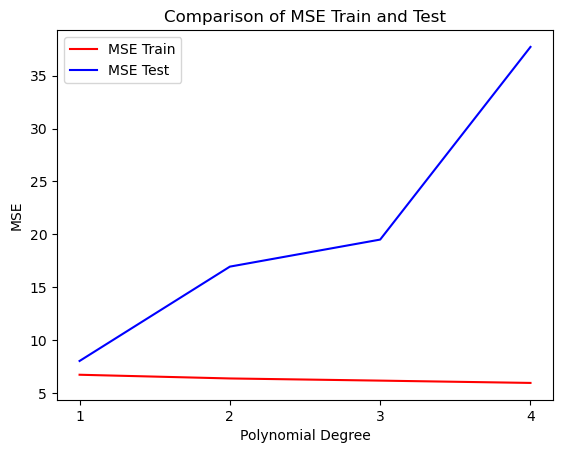

In [21]:
# Plot the training mean squared error (MSE) with a red line
plt.plot(result['mse_train'], color='red', label='MSE Train')

# Plot the testing mean squared error (MSE) with a blue line
plt.plot(result['mse_test'], color='blue', label='MSE Test')

# Label X-axis, Y-axis and Title
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Comparison of MSE Train and Test')

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('MSE.pdf')
plt.show()

### Optimal Quantile :
Now that I know that the optimal degree of polynomial is 1, I create y_pred_test by doing the regression. Then I create a def called quantile_cumulative_returns that return the cumulative_returns of y_pred by investing each month only in the stock that have a return predicted above the selected quantile. Finally I plot in graph the cumualtive return of the test period for different quantile to see the optimal one.

In [22]:
# Generate X_poly_dumies for current optimal degree 1
X_poly_dummies = polynomial(X, 1)
    
# Split the data into training and testing sets without shuffling to preserve time series order
X_train, X_test, y_train, y_test = train_test_split(X_poly_dummies, y, test_size=0.2, shuffle=False)
    
# Predict y_pred_test using the regression model and convert it into a dataframe 
y_pred_test = reg_y_pred(X_train, y_train, X_test)[1]
y_pred_test = pd.DataFrame(y_pred_test, index=y_test.index, columns=['price_future_pred'])

In [23]:
# Calculate the logarithm of the mean squared error 
mse_reg = np.log(mean_squared_error(y_test, y_pred_test))

In [24]:
# Create the new columns names for the 6 first columns
new_column_names = {'0': 'const',
                    '1': 'Vol_1M',
                    '2': 'Mkt_Cap',
                    '3': 'P2B',
                    '4': 'D2E',
                    '5': 'Prof_Marg'}

# Apply column renaming using the rename()
X_train.rename(columns=new_column_names, inplace=True)

In [25]:
# Fit a regression model on the training data
model = sm.OLS(y_train, X_train).fit()

# Print the summary statistics of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           price_future   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        12:44:03   Log-Likelihood:                -27625.
No. Observations:                5760   AIC:                         5.532e+04
Df Residuals:                    5725   BIC:                         5.555e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7028      0.515     80.960      0.0

In [26]:
def quantile_cumulative_returns(price, y, y_pred, quantile):   
    # Concatenate price, y, and y_pred into a single DataFrame named table
    table = pd.concat([price, y, y_pred], axis=1)
    
    # Calculate the return based on actual and predicted future prices
    table['return'] = (table['price_future'] - table['price']) / table['price']
    table['return_pred'] = (table['price_future_pred'] - table['price']) / table['price']
    
    # Determine if the predicted return is above the quantile given for each date
    # overperf is a boolean series where True indicates that the predicted return is above the quantile given
    overperf = table['return_pred'] > table.groupby('Date')['return_pred'].transform(lambda x: x.quantile(quantile))
    overperf = overperf.rename('overperf')
    
    # Concatenate overperf to table 
    table = pd.concat([table, overperf], axis=1)
    
    # Calculate the mean return of the stock that are predicted to overperform for each date
    # Assuming we are investing equally only in the stocks that we predicted to overperfom
    ret = table[table['overperf'] == True].groupby('Date')['return'].mean()
    
    # Calculate the cumulative of ret
    cumulative_ret = cumulative_returns(ret)
    
    return cumulative_ret

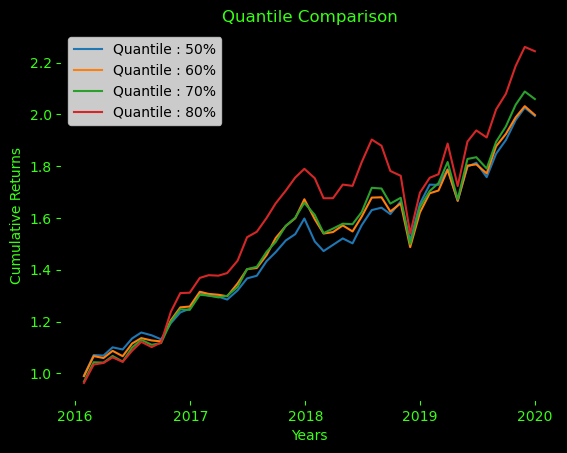

In [27]:
# Loop through 5 to 8 (so a 50% to 80% percentile)
for i in range(5,9):
    # Calculate the cumulative returns of the regression for a strategy that invest 
    # in the 'i*0.1'th quantile of best predicted returns for each dates
    q_c_r_reg = quantile_cumulative_returns(price_test, y_test, y_pred_test, i*0.1)
    # Plot the cumulative returns, labeling each line plot with the corresponding quantile
    plt.plot(q_c_r_reg, label='Quantile : ' + str(i*10) + '%')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Cumulative Returns', color='#39FF14')
plt.title('Quantile Comparison', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('Quantile_comparison.pdf')
plt.show()

In [28]:
q_c_r_reg = quantile_cumulative_returns(price_test, y_test, y_pred_test, 0.8)

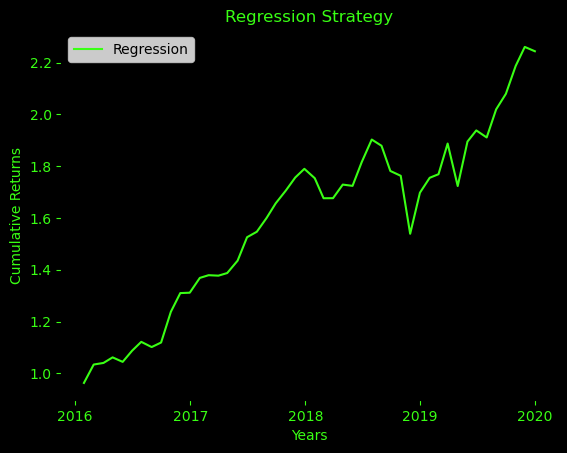

In [29]:
plt.plot(q_c_r_reg, color='#39FF14', label='Regression')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Cumulative Returns', color='#39FF14')
plt.title('Regression Strategy', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('Regression.pdf')
plt.show()

# Feedforward Neural Network (FNN) :
I will now use a feedforward neural network to predict the future price of the stock. I first create the independent variable X_FNN with the 5 smart beta and their associate dummies. I then split the data into train and test. Next, I create the def FNN that return the mse and the y_pred_test of a feedforward neural network trained with X_train and y_train and where I can choose the number of neurons, layers and epochs.

In [30]:
# Combine the X with the dummies and ensure all column names are of string type
X_FNN = pd.concat([X, dummies], axis=1)
X_FNN.columns = X_FNN.columns.astype(str)

# Split the data into training and testing sets without shuffling to preserve time series order
X_train, X_test, y_train, y_test = train_test_split(X_FNN, y, test_size=0.2,shuffle=False)

In [31]:
def FNN(neurons, layers, epochs):
    # Set the seed and the randomness at the random number 10 to assure consistency in results
    random.seed(10)
    np.random.seed(10)
    tf.random.set_seed(10)

    # Initialize a Sequential model
    model = tf.keras.Sequential()

    # Add specified number of layers i and specified number of neurons to the model
    for i in range(layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    # Add output layer with 1 neuron for regression like output
    model.add(tf.keras.layers.Dense(1))

    # Compile the model using Adam optimizer and mean squared error as the loss function
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=epochs)
    
    # Evaluate the model on the test data with the MSE
    mse = np.log(model.evaluate(X_test, y_test))

    # Predict y_pred_test using the model on X_test
    y_pred_test = model.predict(X_test)
    
    # Return the mse and y_pred_test
    return mse, y_pred_test

### Optimization and cumulative return :
I now test the feedforward neural network with different parameters and put the associate mse in a dataframe called result. This cell can take few minutes to run because I test 27 different combinations of parameters. Then I print the most efficient combination of parameters so the one with the lowest mse. Finally I will use quantile_cumulative_returns with a 80% quantile (same as for the regression) with the y_pred_test of the optimal FNN and plot it into a graph.

### The three nexts cells can be skiped if you don't want to wait few minutes

In [32]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['neurons', 'layers', 'epochs', 'mse_test'])

# Loops to iterate over different configurations of neurons, layers, and epochs
for neurons in [8, 16, 32]:
    for layers in [1, 2, 3]:
        for epochs in [5, 10, 20]:
            # Call the FNN function and get the mse
            mse = FNN(neurons, layers, epochs)[0]

            # Create a new row with the current configuration and mse
            new_row = pd.DataFrame({'neurons': [neurons],  
                                    'layers': [layers],
                                    'epochs': [epochs],
                                    'mse_test': [mse]})
            
            # Append the new row to results
            result = pd.concat([result, new_row], ignore_index=True)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3714.1172
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3587.2197
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3367.7168
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3093.8884
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2816.7922
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5042.7124
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3714.1172
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3587.2197
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3367.7168
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3093.8884
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2816.7922
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2569.5134
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2362.6414
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2198.9937

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1883.1897 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3733.1804
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3069.3054
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2045.2269
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1678.4277
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1289.3079
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1796.8275
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3733.1804
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3069.3054
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2045.2269
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1678.4277
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1289.3079
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 937.0775
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1051.8611
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2149.8367
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3720.4832
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3080.5122
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2112.1257
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1727.8481
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1446.7278
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2116.3125
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3720.4832
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3080.5122
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2112.1257
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1727.8481
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1446.7278
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 145.2605
Epoch 20/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 131.9070
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1421.5004 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3731.2908
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3485.6147
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3001.8101
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2502.9312
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2164.8108
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3462.2036
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3731.2908
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3485.6147
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3001.8101
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2502.9312
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 356.7866
Epoch 19/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 328.3928
Epoch 20/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 300.6021
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1696.6271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3411.9038
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1880.2563
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1144.6862
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 689.1455
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 548.1268
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1789.2041
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3411.9038
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1880.2563
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1144.6862
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

In [33]:
result

,neurons,layers,epochs,mse_test
0,8,1,5,8.919637
1,8,1,10,8.590839
2,8,1,20,8.292450
3,8,2,5,8.526894
4,8,2,10,8.142307
5,8,2,20,8.017169
6,8,3,5,7.987105
7,8,3,10,7.734621
8,8,3,20,7.468253
9,16,1,5,8.864310


In [34]:
# Show the row with the smallest MSE value and the optimals parameters
optimal = result['mse_test'].idxmin()
optimal_line = result.loc[optimal:optimal,:]

optimal_line

,neurons,layers,epochs,mse_test
26,32,3,20,7.267093


In [35]:
# Generate y_pred_test for optimal neuron, layer and epoch found
y_pred_test = FNN(32, 3, 20)[1]

# Store the logarithm of the mean squared error 
mse_FNN = FNN(32, 3, 20)[0]

# Convert predictions to DataFrame
y_pred_test = pd.DataFrame(y_pred_test, index=y_test.index, columns=['price_future_pred'])

# Calculate the cumulative returns of the FNN model for a strategy that invest 
# in the stock that are above the 80th quantile of best predicted returns for each dates
q_c_r_fnn = quantile_cumulative_returns(price_test, y_test, y_pred_test, 0.8)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3411.9038
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1880.2563
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1144.6862
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 689.1455
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 548.1268
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 465.1132
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 395.6394
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 336.4219
Epoch 9/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284.2359
Epoch 10/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 238.4620
Epoch 11/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 198.7728
Epoch 12/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166.7776
Epoch 13/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142.5221
Epoch 14/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124.6384
Epoch 15/20
180/180 ━━━━━━

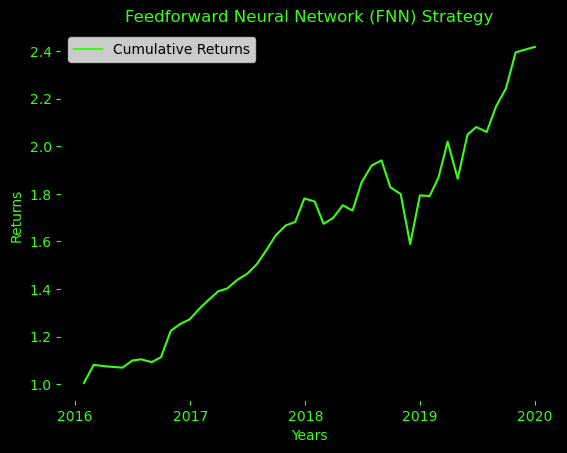

In [36]:
# Plot the cumulative returns of the FNN Strategy
plt.plot(q_c_r_fnn, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')
plt.title('Feedforward Neural Network (FNN) Strategy', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('FNN.pdf')
plt.show()

# Long Short Term Memory (LSTM) :
I will now use a long short term memory neural network to predict the future price of the stock. I first concatenate the dummies to df and then create the dependant variable X_LSTM with the beta and the dummies and the dependant variable y_LSTM with the future prices and price_LSTM with the actual price (because the index order will be different than before). I then create the def LSTM_data that split the data manually into train and test by blocks with a sequence length chosen.

In [37]:
# Reset the index of DataFrame and set stock_name and Date as new index
df = df.reset_index()
df = df.set_index(['stock_name', 'Date'])

# Sort df by the index and reset the index
df = df.sort_index()
df = df.reset_index()

# Generate dummies for the stock_name column and concatenate it to df
dummies = pd.get_dummies(df['stock_name'], drop_first=False)
df = pd.concat([df, dummies], axis=1)

# Set stock_name as the index of df
df = df.set_index(['stock_name'])

In [38]:
# Create X_LSTM with smart beta and dummies 
X_LSTM = df.iloc[:, [2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                     26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]]

# Create y_LSTM with futur price
y_LSTM = df.iloc[:, [7]]

# Create price_LSTM with price
price_LSTM = df.iloc[:, [0, 1]]

In [39]:
def LSTM_data(X_LSTM, y_LSTM, seq_l):  
    # Create empty lists to store training and testing data
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    price_test = []

    # Loop over the 30 stocks and over the training data for each
    for i in range(30): 
        for j in range(int(192/seq_l)): 
            # Create blocks with the chosen sequence lenght and append it to X_train
            block_x = X_LSTM.iloc[(j*seq_l) + (i*240):(j*seq_l) + seq_l + (i*240), :].values   
            X_train.append(block_x)
            # Create blocks with the chosen sequence lenght and append it to y_train
            block_y = y_LSTM.iloc[(j*seq_l) + (i*240):(j*seq_l) + seq_l + (i*240), :].values
            y_train.append(block_y)

    # Loop over the 30 stocks and over the test data for each
    for i in range(30):
        for j in range(int(48/seq_l)): 
            # Create blocks with the chosen sequence lenght and append it to X_test
            block_x = X_LSTM.iloc[192 + (j*seq_l) + (i*240):192 + (j*seq_l) + seq_l + (i*240), :].values
            X_test.append(block_x)
            # Create blocks with the chosen sequence lenght and append it to y_test
            block_y = y_LSTM.iloc[192 + (j*seq_l) + (i*240):192 + (j*seq_l) + seq_l + (i*240), :].values
            y_test.append(block_y)
            # Create blocks with the chosen sequence lenght and append it to price_test
            block_price = price_LSTM.iloc[192 + (j*seq_l) + (i*240): 192 + (j*seq_l) + seq_l + (i*240), :].values
            price_test.append(block_price)

    # Convert lists to arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    price_test = np.array(price_test)
    
    return X_train, y_train, X_test, y_test, price_test

# LSTM Optimization :
I create a def LSTM_function that return the mse of a LSTM where the sequence length and the epochs are input that can be changed. This cell can take few minutes to run. (I keep the optimal neurons and layers numbers that I found in the FNN). I then create a loop with different level of sequence length and epochs and show the optimal parameters with the lowest mse. Finally I will use quantile_cumulative_returns with a 80% quantile (same as for the regression and FNN) with the y_pred_test of the optimal LSTM and plot it into a graph.

In [40]:
def LSTM_function(seq_l, epochs):
    
    # Prepare the data using LSTM_data function above
    LSTM = LSTM_data (X_LSTM, y_LSTM, seq_l)
    X_train = LSTM[0]
    y_train = LSTM[1]
    X_test = LSTM[2]
    y_test = LSTM[3]
    price_test = LSTM[4]
    
    # Set the seed and the randomness at the random number 20 to assure consistency in results
    random.seed(20)
    np.random.seed(20)
    tf.random.set_seed(20)

    # Initialize a Sequential model
    model = tf.keras.Sequential()
    
    # Add 3 layers and with 32 neurons each
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(seq_l, 35)))
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
    
    # Add output layer with 1 neuron for regression like output
    model.add(tf.keras.layers.Dense(1))

    # Compile the model using Adam optimizer and mean squared error as the loss function
    model.compile(optimizer='adam', loss='mse')

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=epochs)
    
    # Evaluate the model on the test data with the MSE
    mse = np.log(model.evaluate(X_test, y_test))
    
    # Predict y_pred using the model on X_test
    y_pred = model.predict(X_test)
       
    # Return the mse and y_pred_test    
    return mse, y_pred

### The three nexts cells can be skiped if you don't want to wait few minutes

In [41]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['seq_length', 'epochs', 'mse_test'])

# Loops to iterate over different configurations of sequence length and epochs
for seq_l in [3,6,12]:
    for epochs in [5,10,20]:
        # Call the LSTM function and get the mse
        mse = LSTM_function(seq_l, epochs)[0]

        # Create a new row with the current configuration and mse
        new_row = pd.DataFrame({'seq_length': [seq_l],  
                                'epochs': [epochs],
                                'mse_test': [mse]})
            
        # Append the new row to the results DataFrame
        result = pd.concat([result, new_row], ignore_index=True)

/Users/Nicolas/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 141462.1406
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 180256.2031
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 135447.8438
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4157.2778
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3182.1804
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10392.7627  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 141462.1406
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 180256.2031
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 135447.8438
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4157.2778
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3182.1804
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2428.2939
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2289.1294
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2281.3174
Epoch 9/

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 749947.9375   
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 513720512.0000
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 170208480.0000
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 133102480.0000
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 75364992.0000
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27765382.0000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78635776.0000   
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 513720512.0000
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 170208480.0000
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 133102480.0000
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 75364992.0000
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 27765382.0000
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24970240.00

In [42]:
result

,seq_length,epochs,mse_test
0,3,5,8.695012
1,3,10,8.700422
2,3,20,8.707257
3,6,5,11.496572
4,6,10,12.762255
5,6,20,13.301606
6,12,5,18.035799
7,12,10,16.136757
8,12,20,14.699890


In [43]:
# Show the row with the lowest mse and the optimals parameters
optimal = result['mse_test'].idxmin()
optimal_line = result.loc[optimal:optimal,:]

optimal_line

,seq_length,epochs,mse_test
0,3,5,8.695012


In [44]:
# Obtain y_pred, y_test, price_test from LSTM model
y_pred = LSTM_function(3, 10)[1]
y_test = LSTM_data(X_LSTM, y_LSTM, 3)[3]
price_test = LSTM_data(X_LSTM, y_LSTM, 3)[4]


# Store the logarithm of the mean squared error 
mse_LSTM = LSTM_function(3, 10)[0]

Epoch 1/10


/Users/Nicolas/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 141462.1406
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 180256.2031
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 135447.8438
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4157.2778
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3182.1804
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2428.2939
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2289.1294
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2281.3174
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2238.3833
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2222.4497
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10086.7490  
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 141462.1406
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 180256.2031
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 135447.8438
Epoch 4/10
60/

In [45]:
# Reshape y_pred, y_test, and price_test by grouping the blocks
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
price_test = price_test.reshape(-1, 2)

# Create dataframe for price_test, y_pred and y_test
price_test = pd.DataFrame(price_test, columns=['Date', 'price'])
price_test = price_test.set_index(['Date'])
index_ = price_test.index
y_pred_test = pd.DataFrame(y_pred, index=index_, columns=['price_future_pred'])
y_test = pd.DataFrame(y_test, index=index_, columns=['price_future'])

# Calculate quantile cumulative returns
q_c_r_lstm = quantile_cumulative_returns(price_test, y_test, y_pred_test, 0.8)

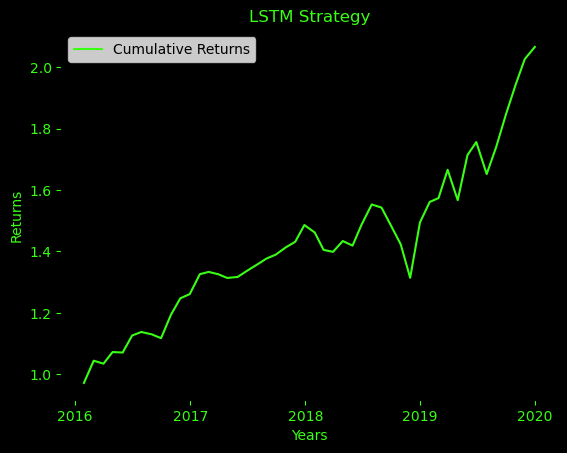

In [46]:
# Plot the cumulative returns of the FNN Strategy
plt.plot(q_c_r_lstm, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')
plt.title('LSTM Strategy', color='#39FF14')

# Setting the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('LSTM.pdf')
plt.show()

# Decision Tree Classifier :


### Restructuring the Dataframe :
I will first add to the dataframe a column called overperform equal True if the future return is greater than the median future return for each date and each stock.

In [47]:
# Add a overperform column to df where each entry is True if the future return
# is greater than the median future return for each date
df['overperform'] = df['return_future'] > df.groupby('Date')['return_future'].transform('median')

# Set stock_name and Date as index and sort the data by the index 
df = df.reset_index()
df = df.set_index(['stock_name', 'Date'])
df = df.sort_index()

### Create new X's and y and Train-Test spliting :
I create the dependant variable y which is the overperform column and the indepedant variable X which is the 5 smart beta. I then split df, y and X into train and test.

In [48]:
# Select the  column overperform of df as y
y_tree = df.iloc[:,41:42]

# Select the 5 smart beta of df as X
X_tree = df.iloc[:,1:6]

# Standardize the X's
X_tree_index = X_tree.index
X_tree_columns = X_tree.columns
scaler = StandardScaler()
X_tree = scaler.fit_transform(X_tree)
X_tree = pd.DataFrame(X_tree, index=X_tree_index, columns=X_tree_columns)

In [49]:
# we can't use the train_test_split function because we have a double index

# Split df between train 80% and test 20%, by manually selecting th date
df_train = df.loc[pd.IndexSlice[:, '2000-01-31':'2015-12-31'],:]
df_test = df.loc[pd.IndexSlice[:, '2016-01-29':'2019-12-31'],:]

# Split X between train 80% and test 20%, by manually selecting th date
X_train = X_tree.loc[pd.IndexSlice[:, '2000-01-31':'2015-12-31'],:]
X_test = X_tree.loc[pd.IndexSlice[:, '2016-01-29':'2019-12-31'],:]

# Split y between train 80% and test 20%, by manually selecting th date
y_train = y_tree.loc[pd.IndexSlice[:, '2000-01-31':'2015-12-31'],:]
y_test = y_tree.loc[pd.IndexSlice[:, '2016-01-29':'2019-12-31'],:]

### Decision Tree Classifier and optimization :
I create a def classifier_tree that create a classifier tree where the max depth and minimum samples leaf can be adjusted. I then run the def with different parameters and put the associate accuracy in a dataframe called result. Then I print the most efficient combination of parameters so the one with the highest accuracy and show its associate tree.

In [50]:
def classifier_tree(depth, leaf):
    # Initializes a Decision Tree Classifier with specified maximum depth and minimum samples per leaf.
    classifier = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)

    # Fits the classifier to the training data
    classifier.fit(X_train, y_train)

    # Predicts y_test_pred for the test dataset X_test
    y_test_pred = classifier.predict(X_test)

    # Calculates the accuracy of the predictions
    accuracy = metrics.accuracy_score(y_test, y_test_pred)

    # Returns the accuracy score
    return accuracy

In [51]:
# Initializes an empty DataFrame result with columns depth, leaf, and accuracy
result = pd.DataFrame(columns=['depth', 'leaf', 'accuracy'])

# Loop over a set of predefined depth and leaf sizes
for depth in [1,2,3,4,5,6]:
    for leaf in [0.01,0.03,0.05,0.07]:
        # Calls the classifier_tree function with the current depth and leaf settings to compute the accuracy
        accuracy = classifier_tree(depth, leaf)
        # Creates a new DataFrame new_row with the current configuration and its computed accuracy
        new_row = pd.DataFrame({'depth': [depth], 'leaf': [leaf], 'accuracy': [accuracy]})
        
        # Appends the new_row to result
        result = pd.concat([result, new_row], ignore_index=True)

# Show result
result

,depth,leaf,accuracy
0,1,0.01,0.479167
1,1,0.03,0.479167
2,1,0.05,0.479167
3,1,0.07,0.479167
4,2,0.01,0.474306
5,2,0.03,0.475000
6,2,0.05,0.486111
7,2,0.07,0.486111
8,3,0.01,0.491667
9,3,0.03,0.492361


In [52]:
# Finds the index of the maximum accuracy
optimal = result['accuracy'].idxmax()

# Find the row corresponding to the optimal accuracy
optimal_line = result.loc[optimal:optimal,:]

# Store the accuracy
accuracy_tree = optimal_line.iloc[:,2]

# Show the optimal row
optimal_line

,depth,leaf,accuracy
18,5,0.05,0.527778


In [53]:
# Create a Decision Tree Classifier with the optimal parameters
classifier = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05)

# Fits training data
classifier.fit(X_train, y_train)

# Predict y_test_pred and convert it to a dataframe
y_test_pred = classifier.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred, index=X_test.index, columns=['y_test_pred'])

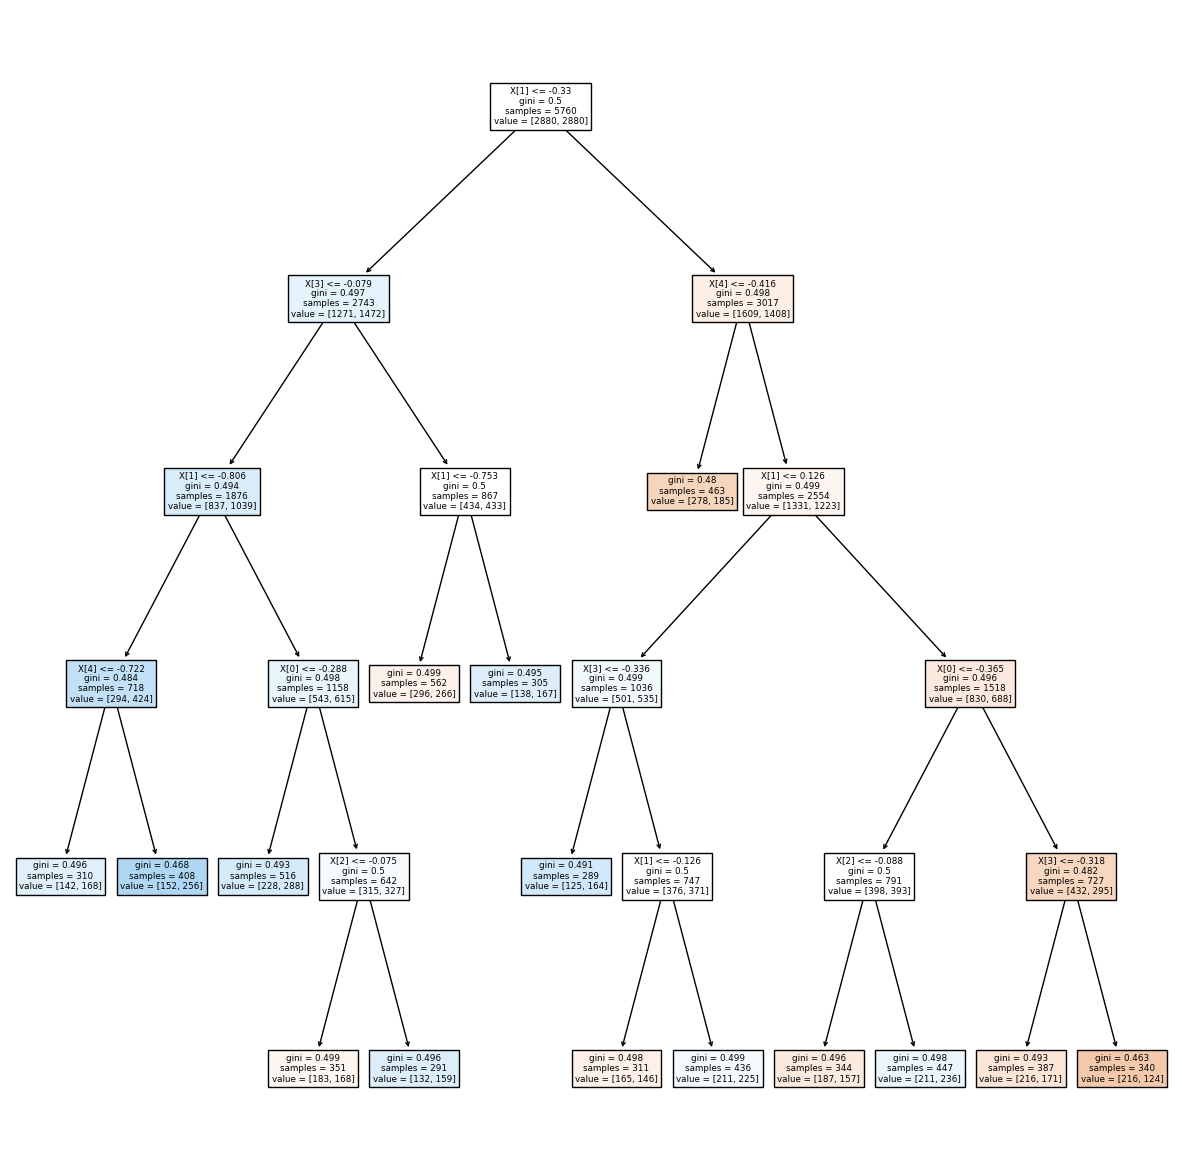

In [54]:
plt.figure(figsize=(15,15))
tree.plot_tree(classifier, filled=True)
plt.savefig('Decision_Tree.pdf')
plt.show()

### Decision Tree Classifier Portoflio's Strategy :
I create a portfolio that invest equally every month in the stocks that are predicted to outperform the mean of futur_returns. Then I plot the cumulative_returns of this portfolio.

In [55]:
# Concatenate y_test_pred with df_test into table
table = pd.concat([y_test_pred, df_test], axis=1)

# Calculate the mean of future return for each date when they are predicted to overperform
monthly_returns = table[table['y_test_pred'] == 1].groupby('Date')['return_future'].mean()

# Calculate the cumulative returns from the monthly average returns
cumulative_tree_returns = cumulative_returns(monthly_returns)

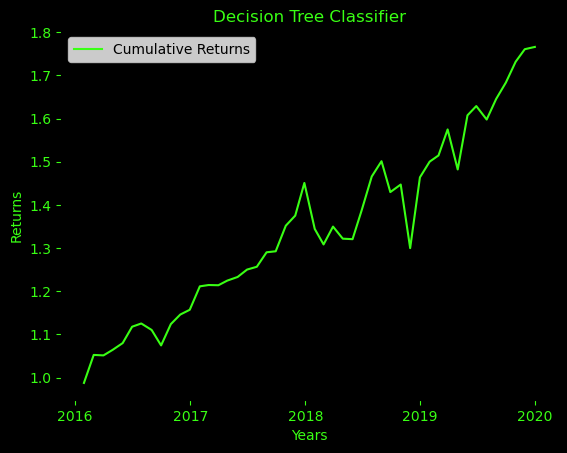

In [56]:
# Plot the cumulative returns of the classifier tree strategy
plt.plot(cumulative_tree_returns, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')
plt.title('Decision Tree Classifier', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('Tree_Returns.pdf')
plt.show()

# Feedforward Neural Network Classifier (FNNC) :
I create the dependant variable y_FNNC which is the overperform column and the independent variable X_FNNC which is the 5 smart beta and the dummies. I then split y and X into train and test.

In [57]:
# Reset the index of df and set stock_name as new index and sort df by the index
df = df.reset_index()
df = df.set_index(['Date'])
df = df.sort_index()

In [58]:
# Create y_FNNC with futur price
y_FNNC = df.iloc[:, [42]]

# Create X_FNNC with smart beta 
X_FNNC = df.iloc[:, [2,3,4,5,6]]

# Create dummies_FNNC with dummies
dummies_FNNC = df.iloc[:, [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                    31,32,33,34,35,36,37,38,39,40,41]]

# Create y_FNNC with futur price
y_FNNC = df.iloc[:, [42]]

# Preserve the index and column names of X_FNNC
X_FNNC_index = X_FNNC.index
X_FNNC_columns = X_FNNC.columns

# Standardize X_FNNC, convert it to a dataframe and and concat the dummies
scaler = StandardScaler()
X_FNNC = scaler.fit_transform(X_FNNC)
X_FNNC = pd.DataFrame(X_FNNC, index=X_FNNC_index, columns=X_FNNC_columns)
X_FNNC = pd.concat([X_FNNC, dummies_FNNC], axis=1)

# Split the data into training and testing sets without shuffling to preserve time series order
X_train, X_test, y_train, y_test = train_test_split(X_FNNC, y_FNNC, test_size=0.2, shuffle=False)

### Optimization and FNNC :
I test the feedforward neural network (with a sigmoid activation so it behaves as a classifier) with different parameters and put the associate accuracy in a dataframe called result. This cell can take few minutes to run because I test 27 different combinations of parameters. Then I print the most efficient combination of parameters so the one with the highest accuracy.

In [59]:
def FNNC(neurons,layers,epochs):
    # Set the seed and the randomness at the random number 30 to assure consistency in results
    random.seed(30)
    np.random.seed(30)
    tf.random.set_seed(30)

    # Initialize a Sequential model
    model = tf.keras.Sequential()
    
    # Add specified number of layers i and specified number of neurons to the model
    for i in range(layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    # Add output layer with 1 neuron for regression like output
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    # Compile the model using Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=epochs)

    # Evaluate the model on the test data with the accuracy
    loss, accuracy = model.evaluate(X_test, y_test)
    
    # Predict y_test_pred using the model on X_test
    y_test_pred = model.predict(X_test)
    
    # Return the accuracy and y_test_pred
    return accuracy, y_test_pred

### The three nexts cells can be skiped if you don't want to wait few minutes

In [60]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['neurons', 'layers','epochs','accuracy'])

# Loops to iterate over different configurations of neurons, layers, and epochs
for neurons in [8,16,32]:
    for layers in [1,2,3]:
        for epochs in [5,10,20]:
            #Call the FNNC function and get the accuracy
            accuracy = FNNC(neurons,layers,epochs)[0]
            
            # Create a new row with the current configuration and accuracy
            new_row = pd.DataFrame({'neurons': [neurons],  
                                    'layers':[int(layers)],
                                    'epochs': [epochs],
                                    'accuracy':[accuracy]})
            
            # Append the new row to the result
            result = pd.concat([result, new_row], ignore_index=True) 

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4781 - loss: 0.7197
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4958 - loss: 0.6994
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5103 - loss: 0.6942
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 0.6921
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5311 - loss: 0.6911
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4947 - loss: 0.7099
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4781 - loss: 0.7197
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4958 - loss: 0.6994
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5103 - loss: 0.6942
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 0.6921
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5311 - loss: 0.6911
Epoch 6/10
180/180 ━━━━━━━━━━━━━━

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5466 - loss: 0.6871
Epoch 12/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5484 - loss: 0.6869
Epoch 13/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5508 - loss: 0.6866
Epoch 14/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5526 - loss: 0.6865
Epoch 15/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5526 - loss: 0.6863
Epoch 16/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5545 - loss: 0.6861
Epoch 17/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5538 - loss: 0.6860
Epoch 18/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5560 - loss: 0.6858
Epoch 19/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5528 - loss: 0.6856
Epoch 20/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5556 - loss: 0.6855
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5141 - loss: 0.6970
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4908 - loss: 0.7050
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5024 - loss: 0.6992
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6906
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.6898
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - loss: 0.6892
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5414 - loss: 0.6887
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - loss: 0.6883
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5408 - loss: 0.6880
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5442 - loss: 0.6877
Epoch 9/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5460 - loss: 0.6874
Epoch 10/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5481 - loss: 0.6872
Epoch 11/20
180/180 ━━━━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4957 - loss: 0.6972
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4726 - loss: 0.6987
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5102 - loss: 0.6932
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 0.6919
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5231 - loss: 0.6909
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5302 - loss: 0.6899
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5384 - loss: 0.6890
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5408 - loss: 0.6884
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5399 - loss: 0.6878
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5437 - loss: 0.6873
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5425 - loss: 0.6869
45/45 ━━━━━━━━━━━━━━━━━━━━ 

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5556 - loss: 0.6858
Epoch 17/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5570 - loss: 0.6856
Epoch 18/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5555 - loss: 0.6854
Epoch 19/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5572 - loss: 0.6851
Epoch 20/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5574 - loss: 0.6849
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5111 - loss: 0.7033
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5095 - loss: 0.6950
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5307 - loss: 0.6913
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5377 - loss: 0.6900
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5431 - loss: 0.6891
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5476 - loss: 0.6882
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5480 - loss: 0.6881
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5538 - loss: 0.6874
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5560 - loss: 0.6868
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5558 - loss: 0.6861
Epoch 9/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5580 - loss: 0.6855
Epoch 10/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5567 - loss: 0.6850
Epoch 11/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5576 - loss: 0.6845
Epoch 12/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5622 - loss: 0.6839
Epoch 13/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5642 - loss: 0.6833
Epoch 14/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5581 - loss: 0.6828
Epoch 15/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5576 - loss: 0.6819
Epoch 16/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

In [61]:
# Show result
result

,neurons,layers,epochs,accuracy
0,8,1,5,0.495139
1,8,1,10,0.494444
2,8,1,20,0.488889
3,8,2,5,0.517361
4,8,2,10,0.512500
5,8,2,20,0.508333
6,8,3,5,0.477778
7,8,3,10,0.477778
8,8,3,20,0.492361
9,16,1,5,0.499306


In [62]:
# Show the row with the heihest accuracy and the optimals parameters
optimal = result['accuracy'].idxmax()
optimal_line = result.loc[optimal:optimal,:]

optimal_line

,neurons,layers,epochs,accuracy
13,16,2,10,0.519444


### FNN Classifier Portoflio's Strategy :
I create a portfolio that invest equally every months in the stocks that are above the 80% quantile of accuracy. Then I plot the cumulative_returns of this portfolio.

In [63]:
# Generate y_test_pred for optimal neuron, layer and epoch found and convert predictions to a dataframe
y_test_pred = FNNC(16,2,10)[1]
y_test_pred = pd.DataFrame(y_test_pred, index=X_test.index, columns=['y_test_pred'])

# Store the accuracy
accuracy_FNNC = FNNC(16,2,10)[0]

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5065 - loss: 0.6983
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5258 - loss: 0.6920
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5329 - loss: 0.6905
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5462 - loss: 0.6894
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5446 - loss: 0.6885
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5421 - loss: 0.6877
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5422 - loss: 0.6870
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5424 - loss: 0.6864
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5431 - loss: 0.6859
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5434 - loss: 0.6855
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5329 - loss: 0.6985
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10
180/180 ━━━━━━━━

In [64]:
# Split df into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

# Concatenate df_test and y_test_pred into table
table = pd.concat([df_test, y_test_pred], axis=1)

# Add a column y_test_pred_quantile to table that
# Compute the mean of the y_test_pred superior to the 80% quantile for each date 
table['y_test_pred_quantile'] = table.groupby('Date')['y_test_pred'].transform(lambda x: x.quantile(0.8))

# Filter rows where y_test_pred is greater than y_test_pred_quanitle 
# Then calculating mean return_future for each date
FNNC_return = table[table['y_test_pred'] > table['y_test_pred_quantile']].groupby('Date')['return_future'].mean()

# Calculate cumulative returns
cumulative_FNNC_returns = cumulative_returns(FNNC_return)

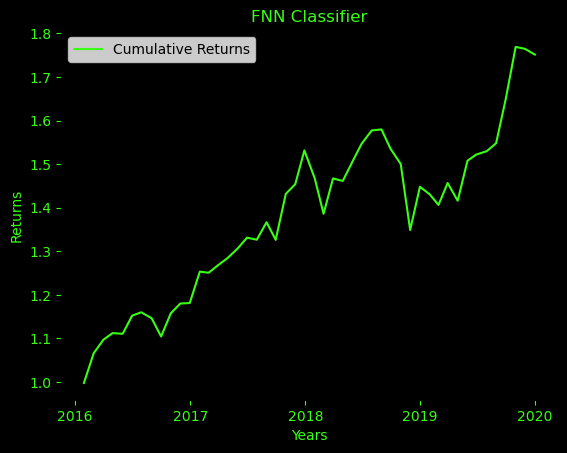

In [65]:
# Plot the cumulative returns of the classifier tree strategy
plt.plot(cumulative_FNNC_returns, color='#39FF14', label='Cumulative Returns')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Returns', color='#39FF14')
plt.title('FNN Classifier', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 

# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('FNNC_Returns.pdf')
plt.show()

# Strategy Comparison :
I plot the ln(mse) of the 3 first strategy and the accuracy of the 2 last strategy in a dataframe. 

In [66]:
# Create an empty DataFrame to store the LN(MSE) of the 3 first strategy.
result = pd.DataFrame(columns=['Strategy','LN(MSE)'])

# Create a new row with each strategies and its LN(MSE)
# Append the new row to result

new_row = pd.DataFrame({'Strategy':['LSTM'],
                        'LN(MSE)':[mse_LSTM]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['Regression'],
                        'LN(MSE)':[mse_reg]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['FNN'],
                        'LN(MSE)':[mse_FNN]})
result = pd.concat([result, new_row], ignore_index=True)

result

,Strategy,LN(MSE)
0,LSTM,8.700422
1,Regression,8.054407
2,FNN,7.267093


In [67]:
# Create an empty DataFrame to store the LN(MSE) of the 3 first strategy.
result = pd.DataFrame(columns=['Strategy','Accuracy'])

# Create a new row with each strategies and its LN(MSE)
# Append the new row to result

new_row = pd.DataFrame({'Strategy':['Decision Tree'],
                        'Accuracy':[accuracy_tree.iloc[0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['FNNC'],
                        'Accuracy':[accuracy_FNNC]})
result = pd.concat([result, new_row], ignore_index=True)

result

,Strategy,Accuracy
0,Decision Tree,0.527778
1,FNNC,0.519444


I plot every strategy cumulative return in a graph and then create a dataframe with the yearly return of every strategy.

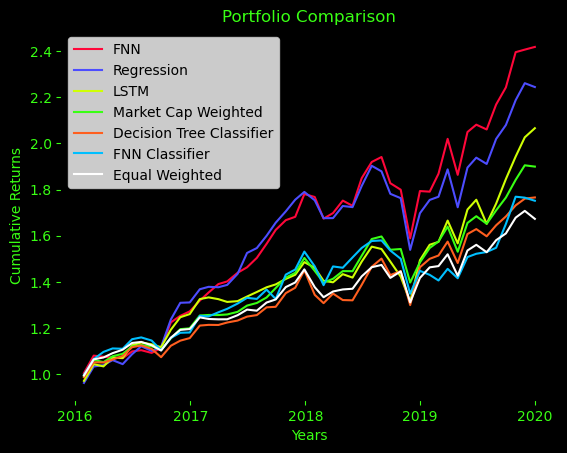

In [68]:
# Plot the cumulative returns of each strategy with a neon color
plt.plot(q_c_r_fnn, color='#FF073A', label='FNN')
plt.plot(q_c_r_reg, color='#4D4DFF', label='Regression')
plt.plot(q_c_r_lstm, color='#CFFF04', label='LSTM')
plt.plot(cumulative_returns_marketcap_test, color='#39FF14', label='Market Cap Weighted')
plt.plot(cumulative_tree_returns, color='#FF5F1F', label='Decision Tree Classifier')
plt.plot(cumulative_FNNC_returns, color='#00BFFF', label='FNN Classifier')
plt.plot(cumulative_returns_equal_test, color='#FFFFFF', label='Equal Weighted')

# Label X-axis, Y-axis and Title
plt.xlabel('Years', color='#39FF14')
plt.ylabel('Cumulative Returns', color='#39FF14')
plt.title('Portfolio Comparison', color='#39FF14')

# Set the X-axis to only show years the beginning of each year.
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set background color to black and axis numbers to neon green
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='#39FF14') 


# Display the legend, export it to pdf and show the graph
plt.legend()
plt.savefig('Comparison.pdf')
plt.show()

In [69]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['Strategy','4-Years Cumulative Return'])

# Create a new row with each strategies and its cumulative return at the last date
# Append the new row to result

new_row = pd.DataFrame({'Strategy':['Equal Weighted'],
                        '4-Years Cumulative Return':[cumulative_returns_equal_test.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['FNN Classifier'],
                        '4-Years Cumulative Return':[cumulative_FNNC_returns.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['Decision Tree Classifier'],
                        '4-Years Cumulative Return':[cumulative_tree_returns.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['Market Cap Weighted'],
                        '4-Years Cumulative Return':[cumulative_returns_marketcap_test.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['LSTM'],
                        '4-Years Cumulative Return':[q_c_r_lstm.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['Regression'],
                        '4-Years Cumulative Return':[q_c_r_reg.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

new_row = pd.DataFrame({'Strategy':['FNN'],
                        '4-Years Cumulative Return':[q_c_r_fnn.iloc[-1][0]]})
result = pd.concat([result, new_row], ignore_index=True)

result = result.set_index(['Strategy'])

# Add a row to result with 4-years return and yearly return 
result['4-Years Return'] = result['4-Years Cumulative Return'] - 1
result['Yearly Return'] = result['4-Years Cumulative Return']**(1/4) - 1

# Show result 4-years return and yearly return 
result.iloc[:,1:3]

,4-Years Return,Yearly Return
Strategy,,
Equal Weighted,0.673223,0.137335
FNN Classifier,0.751643,0.150433
Decision Tree Classifier,0.765972,0.152779
Market Cap Weighted,0.899478,0.173974
LSTM,1.065739,0.198861
Regression,1.243940,0.223919
FNN,1.417602,0.246942
